<a href="https://colab.research.google.com/github/Qjizhi/CSE659/blob/main/Learning_stereo_from_single_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I implement this code baed on the work "Learning stereo from single images, ECCV 2020".

Paper link: [Learning stereo from single images, ECCV 2020](https://arxiv.org/abs/2008.01484).

Name: Feng Qiao.

![](https://neurohive.io/wp-content/uploads/2020/08/thepr.png)



In [ ]:
# 1. install packages
!pip install transformers

In [ ]:
# 2. import libs
from transformers import pipeline
from PIL import Image
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 3. Run depth estimation model, get depth map and disparity map
# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the depth estimation pipeline
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf", device=device)

# Load the image
# image_url = "https://www.cvlibs.net/datasets/kitti/results/a7701b66144e4ead52e7078445fc0ba64ff317b5/image_2/0000000000.png"
image_url = "https://github.com/HKBU-HPML/IRS/blob/master/imgs/left.png?raw=true"
image = Image.open(requests.get(image_url, stream=True).raw)

# Run depth estimation
depth = pipe(image)["depth"]

print(f"Depth estimation completed on {device}.")


Depth estimation completed on cuda.


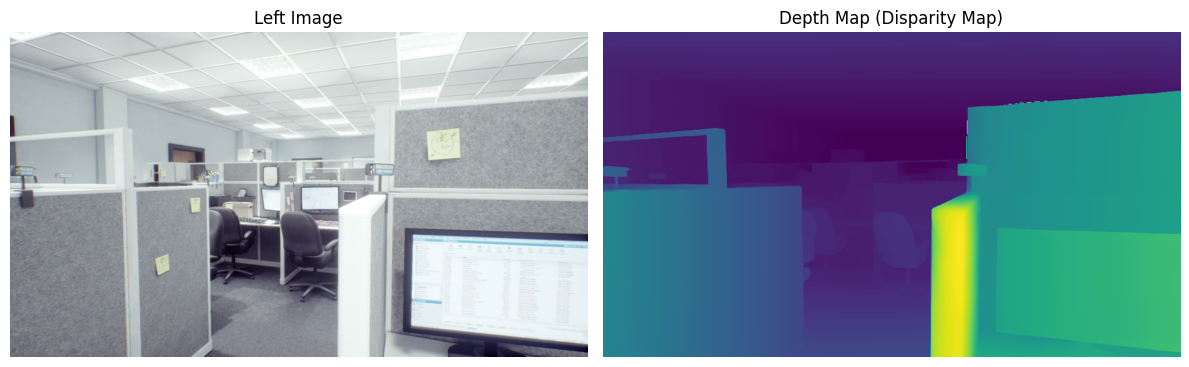

In [ ]:
# 4. visualize image, depth map and disparity map
# Convert depth to a NumPy array and normalize it for visualization
depth_array = np.array(depth)
depth_normalized = (depth_array - depth_array.min()) / (depth_array.max() - depth_array.min())

# Convert the PIL image to a NumPy array for plotting
image_array = np.array(image)

# Create a figure with 2 subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title('Left Image')
plt.axis('off')

# Plot the depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_normalized, cmap='viridis')
# plt.colorbar(label='Normalized Depth')
plt.title('Depth Map (Disparity Map)')
plt.axis('off')

plt.tight_layout()
plt.show()

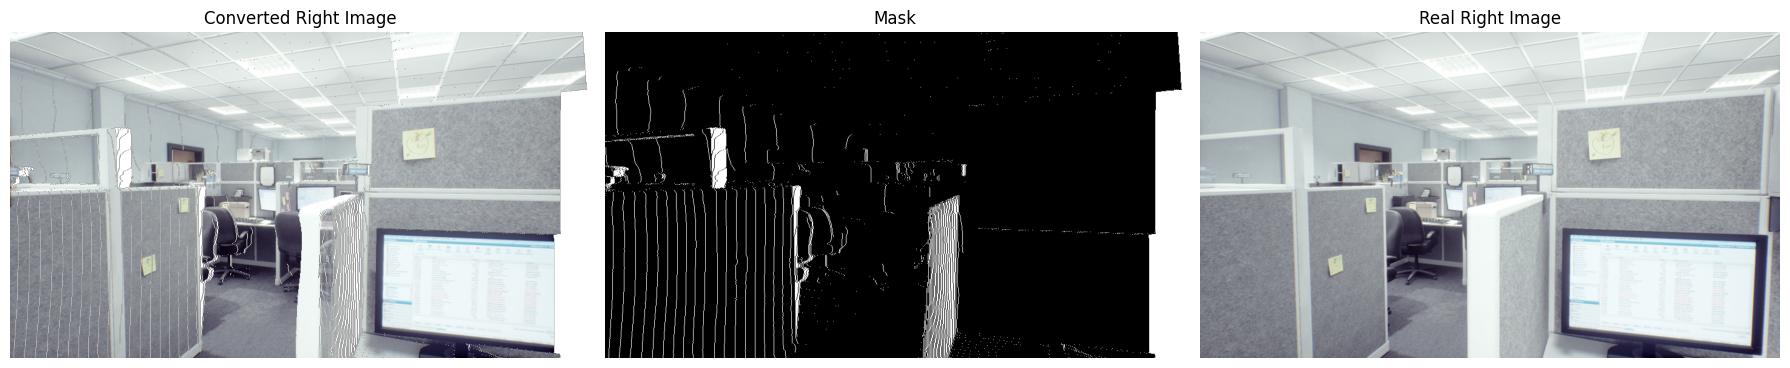

In [ ]:
# 5. warp left image with disparitu map to get converted right image
def warp_image_with_disparity(left_image: Image.Image, disparity_map: np.ndarray) -> (Image.Image, np.ndarray):
    """
    Warp the left image using the disparity map to get the right image and generate a mask.

    Args:
        left_image (Image.Image): The left image to be warped.
        disparity_map (np.ndarray): The disparity map with the same width and height as the left image.

    Returns:
        tuple: (right_image, mask)
            - right_image (Image.Image): The warped right image.
            - mask (np.ndarray): The mask indicating valid pixel locations in the right image.
    """
    # Convert PIL image to NumPy array
    left_image_array = np.array(left_image)
    # Ensure disparity_map is a float for accurate calculations
    disparity_map = disparity_map.astype(float)

    # Get the image dimensions
    height, width = disparity_map.shape

    # Create an empty array for the warped image
    right_image_array = np.zeros_like(left_image_array)
    mask = np.ones((height, width), dtype=np.uint8) * 255

    # Calculate the x-coordinates of the new image (right image)
    for y in range(height):
        for x in range(width):
            # Calculate the new x-coordinate with the disparity
            new_x = int(x - disparity_map[y, x])
            # Ensure the new x-coordinate is within image bounds
            if 0 <= new_x < width:
                right_image_array[y, new_x] = left_image_array[y, x]
                mask[y, new_x] = 0  # Set mask value to 255 where pixel is placed

    # Convert NumPy array back to PIL image
    right_image = Image.fromarray(right_image_array)

    return right_image, mask

# scale the disparity map to 1/3
right_image, mask = warp_image_with_disparity(image, depth_array/3)

# Load the real right image for comparison (assumed to be in the same format)
real_right_image_url = "https://github.com/HKBU-HPML/IRS/blob/master/imgs/right.png?raw=true"
real_right_image = Image.open(requests.get(real_right_image_url, stream=True).raw)

# Convert images and mask to NumPy arrays for plotting
right_image_array = np.array(right_image)
mask_array = np.array(mask)
real_right_image_array = np.array(real_right_image)

# Create a figure with 3 subplots (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Plot the converted right image
plt.subplot(1, 3, 1)
plt.imshow(right_image_array)
plt.title('Converted Right Image')
plt.axis('off')

# Plot the mask
plt.subplot(1, 3, 2)
plt.imshow(mask_array, cmap='gray')
plt.title('Mask')
plt.axis('off')

# Plot the real right image
plt.subplot(1, 3, 3)
plt.imshow(real_right_image_array)
plt.title('Real Right Image')
plt.axis('off')

plt.tight_layout()
plt.show()

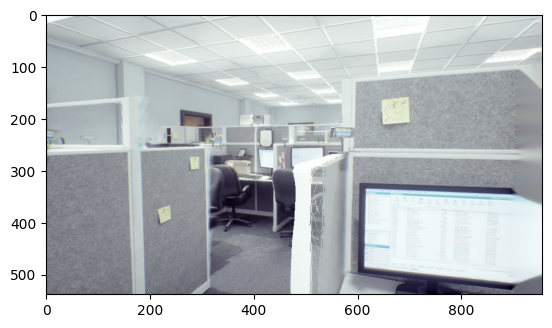

In [ ]:
# 6. inpainting the occlusion areas
def inpaint_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Inpaint the image using the given mask.

    Args:
        image (np.ndarray): The image to be inpainted.
        mask (np.ndarray): The binary mask indicating the regions to inpaint.

    Returns:
        np.ndarray: The inpainted image.
    """
    # Ensure mask is binary (0 or 255)
    mask = (mask > 0).astype(np.uint8) * 255

    # Apply inpainting
    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image

inpainted_image = inpaint_image(np.array(right_image.convert('RGB')), mask_array)
plt.imshow(inpainted_image)

In [ ]:
# 7. Generate more stereo images and using disparity maps from Depth anything V2 as supervision.